<a href="https://colab.research.google.com/github/hackazzo/Univ/blob/main/NetOpt/jupyter_notebooks/Set%20Covering-gurobi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Covering
Quanti bar dobbiamo aprire e dove per coprire tutti gli edifici dell'università a coppito??

In [3]:
## Modules to be installed 
!pip install -i https://pypi.gurobi.com gurobipy 

import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.gurobi.com
     |████████████████████████████████| 11.1MB 2.7MB/s 


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Campus map graph

In [ ]:
buildings = ['Delta6',
             'Hospital',
             'Block11A',
             'Block11E',
             'Coppito2',
             'Coppito1',
             'Block0',
             'StudentCenter',
             'Lab',
             'ComputerCenter']

G = nx.Graph() # creo il grafo

G.add_nodes_from(buildings) # aggiungo i nodi

# aggiungo gli archi
G.add_edge('Delta6','Hospital')
G.add_edge('Delta6','Block11A')
G.add_edge('Block11A','Hospital')
G.add_edge('Block11E','Hospital')
G.add_edge('Block11E','Coppito2')
G.add_edge('Coppito1','Coppito2')
G.add_edge('StudentCenter','Coppito2')
G.add_edge('Coppito1','StudentCenter')
G.add_edge('StudentCenter','Lab')
G.add_edge('StudentCenter','Block0')
G.add_edge('Lab','ComputerCenter')
G.add_edge('ComputerCenter','StudentCenter')
G.add_edge('Coppito1','Block0')
G.add_edge('Block0','Lab')
G.add_edge('Lab','ComputerCenter')
G.add_edge('ComputerCenter','Block0')

print("#nodes ", G.number_of_nodes(), "\n")
print(G.nodes, "\n")
print("#edges ", G.number_of_edges(), "\n")
print(G.edges)

#nodes  10 

['Delta6', 'Hospital', 'Block11A', 'Block11E', 'Coppito2', 'Coppito1', 'Block0', 'StudentCenter', 'Lab', 'ComputerCenter'] 

#edges  15 

[('Delta6', 'Hospital'), ('Delta6', 'Block11A'), ('Hospital', 'Block11A'), ('Hospital', 'Block11E'), ('Block11E', 'Coppito2'), ('Coppito2', 'Coppito1'), ('Coppito2', 'StudentCenter'), ('Coppito1', 'StudentCenter'), ('Coppito1', 'Block0'), ('Block0', 'StudentCenter'), ('Block0', 'Lab'), ('Block0', 'ComputerCenter'), ('StudentCenter', 'Lab'), ('StudentCenter', 'ComputerCenter'), ('Lab', 'ComputerCenter')]


In [ ]:
%matplotlib inline

In [ ]:
pos = nx.spring_layout(G, k=1, seed=10) # tiene le posizioni dei nodi sul disegno

In [ ]:
pos

{'Delta6': array([-0.07509172, -1.        ]),
 'Hospital': array([-0.28234298, -0.52647204]),
 'Block11A': array([-0.35528857, -0.94072138]),
 'Block11E': array([-0.58986166, -0.11435901]),
 'Coppito2': array([-0.32836244,  0.34275659]),
 'Coppito1': array([-0.08210325,  0.65035294]),
 'Block0': array([0.27248336, 0.29336027]),
 'StudentCenter': array([0.2187272 , 0.53530193]),
 'Lab': array([0.58779835, 0.20640544]),
 'ComputerCenter': array([0.63404172, 0.55337525])}

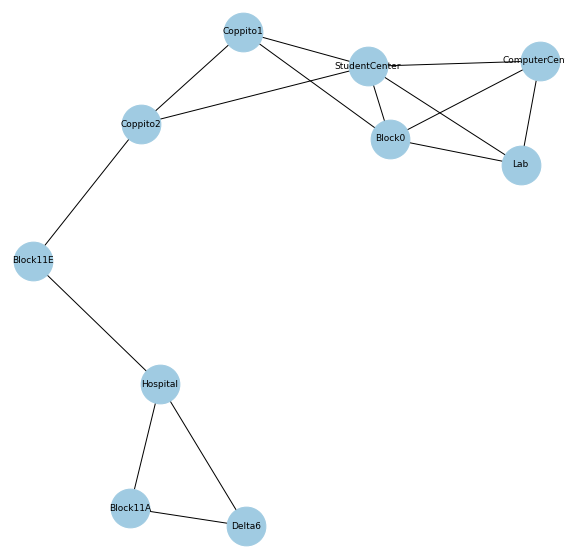

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

nx.draw(G,
        pos,
        ax,
        node_color='#A0CBE2',
        width=1,
        node_size=1500,
        with_labels=True,
        font_size=9,
        font_color='k')

In [ ]:
G.neighbors('Delta6') # ritorna un iteratore

In [ ]:
# creo un dizionario con tutti i vicini dei nodi
subsets = dict()

# il ''+i' aggiunge il nodo stess oalla lista dei suoi vicini
subsets = {i : list(G.neighbors(i)) + [i] for i in G.nodes()} 
subsets

{'Delta6': ['Hospital', 'Block11A', 'Delta6'],
 'Hospital': ['Delta6', 'Block11A', 'Block11E', 'Hospital'],
 'Block11A': ['Delta6', 'Hospital', 'Block11A'],
 'Block11E': ['Hospital', 'Coppito2', 'Block11E'],
 'Coppito2': ['Block11E', 'Coppito1', 'StudentCenter', 'Coppito2'],
 'Coppito1': ['Coppito2', 'StudentCenter', 'Block0', 'Coppito1'],
 'Block0': ['StudentCenter', 'Coppito1', 'Lab', 'ComputerCenter', 'Block0'],
 'StudentCenter': ['Coppito2',
  'Coppito1',
  'Lab',
  'Block0',
  'ComputerCenter',
  'StudentCenter'],
 'Lab': ['StudentCenter', 'ComputerCenter', 'Block0', 'Lab'],
 'ComputerCenter': ['Lab', 'StudentCenter', 'Block0', 'ComputerCenter']}

## Matrice di Incidenza A mxn
Sulle righe abbiamo gli n edifici e sulle colonne gli m vicini

\begin{array}{c|ccccccccc}
  & \texttt{Delta6} & \texttt{Hospital} & \texttt{Block11A} & \texttt{Block11E} & \texttt{Coppito2} 
  & \texttt{Coppito1} & \texttt{Block0} & \texttt{Lab} & \texttt{ComputerCenter} & \texttt{StudentCenter}\\
  \hline
\texttt{Delta6}   & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{Hospital} & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{Block11A} & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{Block11E} & 0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
\texttt{Coppito2} & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 1\\
\texttt{Coppito1} & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 1\\
\texttt{Block0}   & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1\\
\texttt{Lab}      & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
\texttt{ComputerCenter} & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
\texttt{StudentCenter} & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1\\
\end{array}

## Decision variables



$$x_i = \begin{cases} 1 \text{ if subset } i \text { is selected (if the facility is opened on building $i$) }\\ 0 \text{ otherwise.}  \end{cases}$$

In [ ]:
setcovering = gb.Model()

x = setcovering.addVars(buildings, 
                        vtype = gb.GRB.BINARY,
                        name = 'x')

setcovering.update()
x

{'Delta6': <gurobi.Var x[Delta6]>,
 'Hospital': <gurobi.Var x[Hospital]>,
 'Block11A': <gurobi.Var x[Block11A]>,
 'Block11E': <gurobi.Var x[Block11E]>,
 'Coppito2': <gurobi.Var x[Coppito2]>,
 'Coppito1': <gurobi.Var x[Coppito1]>,
 'Block0': <gurobi.Var x[Block0]>,
 'StudentCenter': <gurobi.Var x[StudentCenter]>,
 'Lab': <gurobi.Var x[Lab]>,
 'ComputerCenter': <gurobi.Var x[ComputerCenter]>}

## Objective function

In [ ]:
setcovering.setObjective(x.sum(), gb.GRB.MINIMIZE)

setcovering.write('setcov.lp')

## Constraints 
Constrain di copertura => ogni struttura deve essere copera da un Bar

$$
\sum_{i \in S(j)} x_i \ge 1 \;\;\; j \in V
$$

In [ ]:
setcovering.addConstrs((x.sum(subsets[j]) >=1 for j in subsets),\
                       name='Cover')

{'Delta6': <gurobi.Constr *Awaiting Model Update*>,
 'Hospital': <gurobi.Constr *Awaiting Model Update*>,
 'Block11A': <gurobi.Constr *Awaiting Model Update*>,
 'Block11E': <gurobi.Constr *Awaiting Model Update*>,
 'Coppito2': <gurobi.Constr *Awaiting Model Update*>,
 'Coppito1': <gurobi.Constr *Awaiting Model Update*>,
 'Block0': <gurobi.Constr *Awaiting Model Update*>,
 'StudentCenter': <gurobi.Constr *Awaiting Model Update*>,
 'Lab': <gurobi.Constr *Awaiting Model Update*>,
 'ComputerCenter': <gurobi.Constr *Awaiting Model Update*>}

In [ ]:
setcovering.update()
setcovering.write('setcov.lp')

In [ ]:
setcovering.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 10 rows, 10 columns and 40 nonzeros
Model fingerprint: 0xb7ebd306
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 10 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%


In [ ]:
# Stampiamo la soluzione
print('Number of activated facilities: %g' % setcovering.objVal)
print('Activated facilities:')

activated = list()

for name, var in x.items():
    if var.x > 0.1:
        activated.append(name)
        print (name)

Number of activated facilities: 2
Activated facilities:
Hospital
StudentCenter


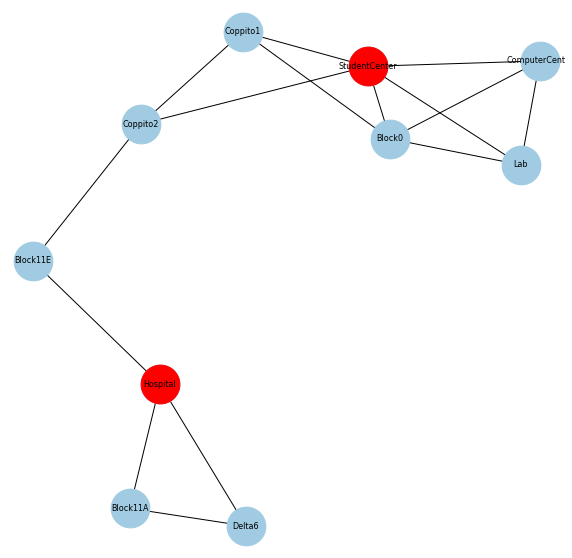

In [ ]:
# disegnamo la soluzione sul grafo
fig, ax = plt.subplots(1, 1, figsize=(10,10))


# disegno il grafo 
nx.draw(G, pos, node_color='#A0CBE2',width=1,node_size=1500,
        with_labels=True, font_size=8)

# ridisegno i nodi attivati colorati di rosso, sopra al grafo
nx.draw_networkx_nodes(G, pos, nodelist=activated, node_size=1500, node_color ='r')